# Importing

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy

In [5]:
user1_df = pd.read_csv("user1_presence_data_60.csv")
user2_df = pd.read_csv("user2_presence_data_60.csv")

# Feature Engineering

In [8]:
user1_df["time"] = pd.to_datetime(user1_df["time"])
user2_df["time"] = pd.to_datetime(user2_df["time"])

for df in [user1_df, user2_df]:
    df["hour"] = df["time"].dt.hour
    df["minute"] = df["time"].dt.minute
    df["day_of_week"] = df["time"].dt.day_name() 
    df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"])

In [10]:
user1_df

,time,state,hour,minute,day_of_week,is_weekend
0,2022-04-24 00:01:00+00:00,living room,0,1,Sunday,True
1,2022-04-24 00:01:30+00:00,living room,0,1,Sunday,True
2,2022-04-24 00:02:00+00:00,living room,0,2,Sunday,True
3,2022-04-24 00:02:30+00:00,living room,0,2,Sunday,True
4,2022-04-24 00:03:00+00:00,living room,0,3,Sunday,True
...,...,...,...,...,...,...
172793,2022-06-22 23:57:30+00:00,bedroom,23,57,Wednesday,False
172794,2022-06-22 23:58:00+00:00,bedroom,23,58,Wednesday,False
172795,2022-06-22 23:58:30+00:00,bedroom,23,58,Wednesday,False
172796,2022-06-22 23:59:00+00:00,bedroom,23,59,Wednesday,False


In [12]:
user2_df

,time,state,hour,minute,day_of_week,is_weekend
0,2022-04-24 00:00:00+00:00,bedroom,0,0,Sunday,True
1,2022-04-24 00:00:30+00:00,bedroom,0,0,Sunday,True
2,2022-04-24 00:01:00+00:00,living room,0,1,Sunday,True
3,2022-04-24 00:01:30+00:00,living room,0,1,Sunday,True
4,2022-04-24 00:02:00+00:00,living room,0,2,Sunday,True
...,...,...,...,...,...,...
172795,2022-06-22 23:57:30+00:00,bedroom,23,57,Wednesday,False
172796,2022-06-22 23:58:00+00:00,bedroom,23,58,Wednesday,False
172797,2022-06-22 23:58:30+00:00,bedroom,23,58,Wednesday,False
172798,2022-06-22 23:59:00+00:00,bedroom,23,59,Wednesday,False


In [14]:
user1_finaldf = user1_df.copy()
user2_finaldf = user2_df.copy()

In [16]:
user1_finaldf["prev_state"] = user1_df["state"].shift(1)
user2_finaldf["prev_state"] = user2_df["state"].shift(1)

In [18]:
user1_finaldf.fillna(method="bfill", inplace=True)
user2_finaldf.fillna(method="bfill", inplace=True)

C:\Users\hanzj\AppData\Local\Temp\ipykernel_5756\2759098192.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  user1_finaldf.fillna(method="bfill", inplace=True)
C:\Users\hanzj\AppData\Local\Temp\ipykernel_5756\2759098192.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  user2_finaldf.fillna(method="bfill", inplace=True)


In [20]:
user1_finaldf.head(10)

,time,state,hour,minute,day_of_week,is_weekend,prev_state
0,2022-04-24 00:01:00+00:00,living room,0,1,Sunday,True,living room
1,2022-04-24 00:01:30+00:00,living room,0,1,Sunday,True,living room
2,2022-04-24 00:02:00+00:00,living room,0,2,Sunday,True,living room
3,2022-04-24 00:02:30+00:00,living room,0,2,Sunday,True,living room
4,2022-04-24 00:03:00+00:00,living room,0,3,Sunday,True,living room
5,2022-04-24 00:03:30+00:00,living room,0,3,Sunday,True,living room
6,2022-04-24 00:04:00+00:00,living room,0,4,Sunday,True,living room
7,2022-04-24 00:04:30+00:00,living room,0,4,Sunday,True,living room
8,2022-04-24 00:05:00+00:00,outside,0,5,Sunday,True,living room
9,2022-04-24 00:05:30+00:00,outside,0,5,Sunday,True,outside


In [22]:
user2_finaldf.head(10)

,time,state,hour,minute,day_of_week,is_weekend,prev_state
0,2022-04-24 00:00:00+00:00,bedroom,0,0,Sunday,True,bedroom
1,2022-04-24 00:00:30+00:00,bedroom,0,0,Sunday,True,bedroom
2,2022-04-24 00:01:00+00:00,living room,0,1,Sunday,True,bedroom
3,2022-04-24 00:01:30+00:00,living room,0,1,Sunday,True,living room
4,2022-04-24 00:02:00+00:00,living room,0,2,Sunday,True,living room
5,2022-04-24 00:02:30+00:00,living room,0,2,Sunday,True,living room
6,2022-04-24 00:03:00+00:00,living room,0,3,Sunday,True,living room
7,2022-04-24 00:03:30+00:00,living room,0,3,Sunday,True,living room
8,2022-04-24 00:04:00+00:00,living room,0,4,Sunday,True,living room
9,2022-04-24 00:04:30+00:00,bedroom,0,4,Sunday,True,living room


# EDA

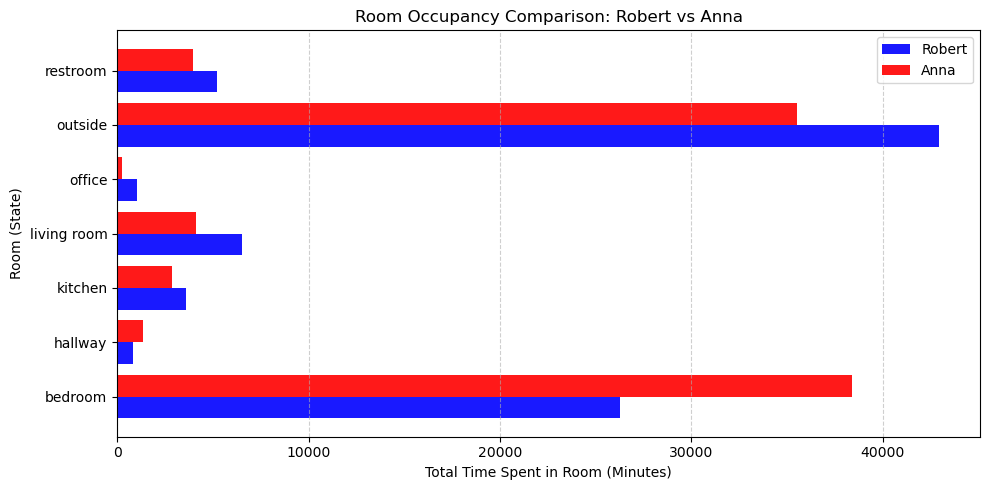

In [25]:
state_counts_user1 = user1_df['state'].value_counts() / 2  
state_counts_user2 = user2_df['state'].value_counts() / 2  

all_states = sorted(set(state_counts_user1.index).union(set(state_counts_user2.index)))
user1_counts = state_counts_user1.reindex(all_states, fill_value=0)
user2_counts = state_counts_user2.reindex(all_states, fill_value=0)

bar_width = 0.4
y = np.arange(len(all_states))

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(y - bar_width/2, user1_counts, bar_width, label='Robert', color='blue', alpha=0.9)
ax.barh(y + bar_width/2, user2_counts, bar_width, label='Anna', color='red', alpha=0.9)

ax.set_yticks(y)
ax.set_yticklabels(all_states)
ax.set_title("Room Occupancy Comparison: Robert vs Anna")
ax.set_ylabel("Room (State)")
ax.set_xlabel("Total Time Spent in Room (Minutes)")
ax.legend()
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

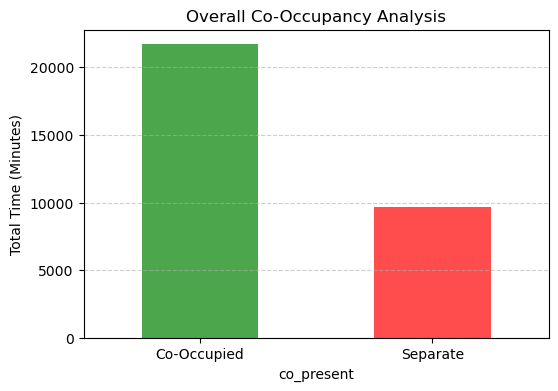

In [27]:
user1_df['time'] = pd.to_datetime(user1_df['time'])
user2_df['time'] = pd.to_datetime(user2_df['time'])

merged_df = pd.merge(user1_df[['time', 'state']], user2_df[['time', 'state']], on='time', suffixes=('_user1', '_user2'))
merged_df['co_present'] = merged_df['state_user1'] == merged_df['state_user2']
merged_df = merged_df[(merged_df['state_user1'] != 'outside') & (merged_df['state_user2'] != 'outside')]

co_occurrence_counts = merged_df['co_present'].value_counts() / 2  
co_occurrence_per_room = merged_df[merged_df['co_present']]['state_user1'].value_counts() / 2

fig, ax = plt.subplots(figsize=(6, 4))
co_occurrence_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7, ax=ax)
ax.set_xticklabels(['Co-Occupied', 'Separate'], rotation=0)
ax.set_ylabel("Total Time (Minutes)")
ax.set_title("Overall Co-Occupancy Analysis")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


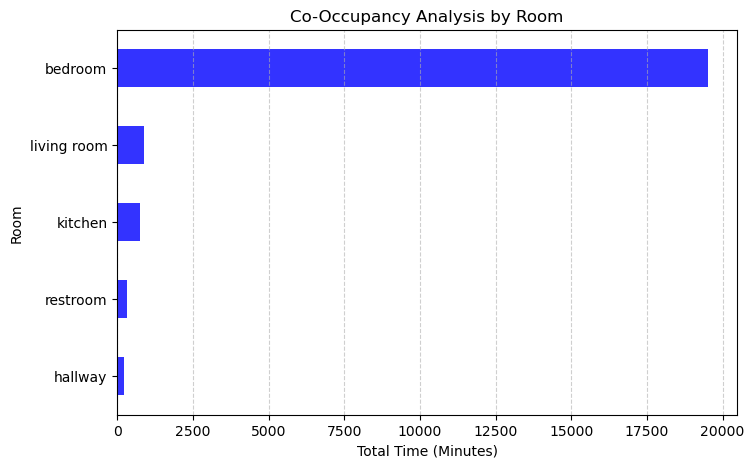

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
co_occurrence_per_room.sort_values().plot(kind='barh', color='blue', alpha=0.8, ax=ax)
ax.set_xlabel("Total Time (Minutes)")
ax.set_ylabel("Room")
ax.set_title("Co-Occupancy Analysis by Room")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

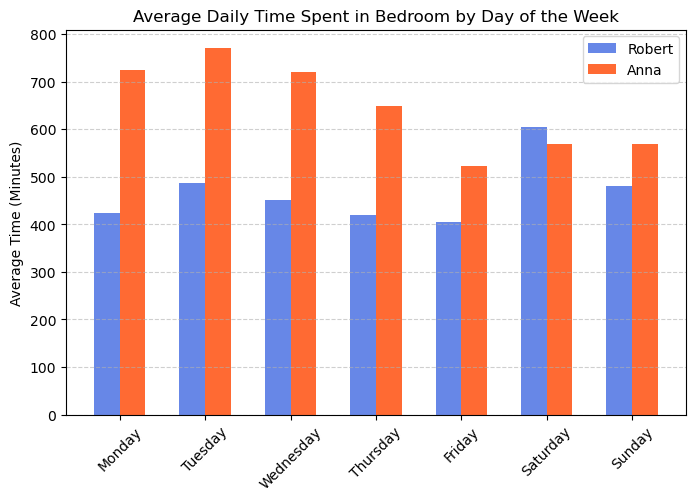

In [31]:
user1_df['time'] = pd.to_datetime(user1_df['time'])
user2_df['time'] = pd.to_datetime(user2_df['time'])

user1_df['day_of_week'] = user1_df['time'].dt.day_name()
user1_df['date'] = user1_df['time'].dt.date
user2_df['day_of_week'] = user2_df['time'].dt.day_name()
user2_df['date'] = user2_df['time'].dt.date

bedroom_user1 = user1_df[user1_df['state'] == 'bedroom']
bedroom_user2 = user2_df[user2_df['state'] == 'bedroom']

bedroom_time_user1 = bedroom_user1.groupby(['day_of_week', 'date']).size().unstack().mean(axis=1) / 2
bedroom_time_user2 = bedroom_user2.groupby(['day_of_week', 'date']).size().unstack().mean(axis=1) / 2

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
bedroom_time_user1 = bedroom_time_user1.reindex(weekdays, fill_value=0)
bedroom_time_user2 = bedroom_time_user2.reindex(weekdays, fill_value=0)

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.3
x = np.arange(len(weekdays))

ax.bar(x - bar_width/2, bedroom_time_user1, bar_width, label="Robert", color="royalblue", alpha=0.8)
ax.bar(x + bar_width/2, bedroom_time_user2, bar_width, label="Anna", color="orangered", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(weekdays, rotation=45)
ax.set_title("Average Daily Time Spent in Bedroom by Day of the Week")
ax.set_ylabel("Average Time (Minutes)")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()